# 1. Prepare Datasets

## Import the S3 data into SageMaker

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Store S3 locations

In [14]:
s3_public_path_kaggle = "s3://collegeaffordability317/Kaggle/"
s3_public_path_tuition = "s3://collegeaffordability317/TuitionTracker/"
s3_public_path_usda = "s3://collegeaffordability317/USDA/"
s3_public_path_usde = "s3://collegeaffordability317/USDE/"

In [15]:
%store s3_public_path_kaggle
%store s3_public_path_tuition
%store s3_public_path_usda
%store s3_public_path_usde

Stored 's3_public_path_kaggle' (str)
Stored 's3_public_path_tuition' (str)
Stored 's3_public_path_usda' (str)
Stored 's3_public_path_usde' (str)


## Show all the data files for the project

In [16]:
!aws s3 ls $s3_public_path_kaggle

2024-03-17 16:07:03   15143141 college_data.csv


In [17]:
!aws s3 ls $s3_public_path_tuition

2024-03-17 16:07:00      21527 DataDictionary.xlsx
2024-03-17 16:07:00     838246 GradRates.csv
2024-03-17 16:07:01    1319314 NetPrice.csv
2024-03-17 16:07:01    1382164 RetentionRates.csv
2024-03-17 16:07:02     653000 StickerPrice.csv


In [18]:
!aws s3 ls $s3_public_path_usda

2024-03-17 16:06:57    1610608 Education.xlsx
2024-03-17 16:06:58    1047684 PopulationEstimates.xlsx
2024-03-17 16:06:58     604165 PovertyEstimates.xlsx
2024-03-17 16:06:59    2762055 Unemployment.xlsx


In [19]:
!aws s3 ls $s3_public_path_usde

2024-03-17 16:06:52      59904 FedStudentAidPortfolioByAge.xls
2024-03-17 16:06:53      68096 FedStudentAidPortfolioByDebtSize.xls
2024-03-17 16:06:53      62976 FedStudentAidPortfolioByLoanType.xls
2024-03-17 16:06:53      50176 FedStudentAidPortfolioByLocation.xls
2024-03-17 16:06:54      60928 FedStudentAidPortfolioBySchoolType.xls
2024-03-17 16:06:54      61952 FedStudentAidPortfolioSummary.xls
2024-03-17 16:06:55      52224 PortfolioByAgeAndDebtSize.xls
2024-03-17 16:06:55      91648 PortfolioByDelinquencyStatus.xls
2024-03-17 16:06:56      57856 PortfolioByLocationAndAge.xls
2024-03-17 16:06:56      58368 PortfolioByLocationAndDebtSize.xls
2024-03-17 16:06:56     147456 PortfolioByRepaymentPlan.xls


# 2. Athena DB

In [20]:
from pyathena import connect

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [21]:
# Set Athena parameters
database_name = 'collegeaffordability317'
table_name = 'college_data'

In [22]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [23]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

""


In [24]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(10)

,database_name
0,collegeaffordability317
1,default
2,dsoaws


In [25]:
# Drop the table if it already exists
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)

# Define the CREATE TABLE statement with data types in lowercase
statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
    unitid int,
    instnm string,
    city string,
    stabbr string,
    zip string,
    region string,
    preddeg string,
    locale string,
    latitude float,
    longitude float,
    ccbasic string,
    ccugprof string,
    ccsizset string,
    adm_rate_all float,
    pptug_ef float,
    sat_avg_all float,
    costt4_a float,
    control string,
    tuitionfee_in float,
    tuitionfee_out float,
    median_hh_inc float,
    mn_earn_wne_indep0_p10 float,
    mn_earn_wne_indep1_p10 float,
    ugds_white float,
    ugds_black float,
    ugds_hisp float,
    ugds_asian float,
    ugds_aian float,
    ugds_nhpi float,
    ugds_2mor float,
    ugds_nra float,
    ugds_unkn float,
    year int
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION 's3://collegeaffordability317/Kaggle/'
"""

In [26]:
# Execute the CREATE TABLE statement
table_1 = pd.read_sql(statement, conn)

In [27]:
# Drop the table if it already exists
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)

# Define the CREATE TABLE statement with data types in lowercase
statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
    unitid int,
    inst_nm string,
    nonres_alien_4yr int,
    unkown_ethn_4yr int,
    grand_total_4yr int,
    hispanic_4yr int,
    amindian_alaskanative_4yr int,
    asian_4yr int,
    black_african_4yr int,
    native_hawaiian_4yr int,
    unknown_ethn_2yr int, 
    grand_total_2_yr int,
    hispanic_2yr int,
    amindian_alaskanative_2yr int,
    asian_2yr int,
    black_african_2yr int,
    native_hawaiian_2yr int,
    white_2yr int,
    two_or_more_race_2yr int,
    unnamed float
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION 's3://collegeaffordability317/TuitionTracker/'
"""

In [28]:
# Execute the CREATE TABLE statement
table_2 = pd.read_sql(statement, conn)

# 2. Exploratory Data Analysis

In [29]:
import csv

df_colleges = pd.read_csv(s3_public_path_kaggle + 
                          "college_data.csv")
df_colleges.shape

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(58123, 33)

In [30]:
df_gradrate = pd.read_csv(s3_public_path_tuition + 
                          "GradRates.csv")
df_netprice = pd.read_csv(s3_public_path_tuition + 
                          "NetPrice.csv")
df_retentionrate = pd.read_csv(s3_public_path_tuition + 
                          "RetentionRates.csv")
df_stickerprice = pd.read_csv(s3_public_path_tuition + 
                          "StickerPrice.csv")

In [31]:
df_stickerprice.head()

,UnitID,Institution Name,Sector of institution (HD2021),Total price for in-state students living on campus 2021-22 (DRVIC2021),Total price for in-state students living off campus (not with family) 2021-22 (DRVIC2021),Total price for in-state students living off campus (with family) 2021-22 (DRVIC2021),Total price for in-state students living on campus 2020-21 (DRVIC2020),Total price for in-state students living off campus (not with family) 2020-21 (DRVIC2020),Total price for in-state students living off campus (with family) 2020-21 (DRVIC2020),Total price for in-state students living on campus 2019-20 (DRVIC2019),...,Total price for in-state students living off campus (with family) 2014-15 (DRVIC2014),Total price for in-state students living on campus 2013-14 (DRVIC2013_RV),Total price for in-state students living off campus (not with family) 2013-14 (DRVIC2013_RV),Total price for in-state students living off campus (with family) 2013-14 (DRVIC2013_RV),Total price for in-state students living on campus 2012-13 (DRVIC2012_RV),Total price for in-state students living off campus (not with family) 2012-13 (DRVIC2012_RV),Total price for in-state students living off campus (with family) 2012-13 (DRVIC2012_RV),Total price for in-state students living on campus 2011-12 (DRVIC2011_RV),Total price for in-state students living off campus (not with family) 2011-12 (DRVIC2011_RV),Total price for in-state students living off campus (with family) 2011-12 (DRVIC2011_RV)
0,180203,Aaniiih Nakoda College,1,NaN,17030.0,8510.0,NaN,17030.0,8510.0,NaN,...,8510.0,NaN,17030.0,8510.0,NaN,17030.0,8510.0,NaN,17030.0,8510.0
1,222178,Abilene Christian University,2,55500.0,55500.0,43872.0,53672.0,53672.0,42322.0,51887.0,...,34100.0,41800.0,41800.0,33000.0,39900.0,39900.0,31250.0,38250.0,NaN,NaN
2,497037,Abilene Christian University-Undergraduate Online,2,NaN,30670.0,19042.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,138558,Abraham Baldwin Agricultural College,1,15727.0,13965.0,7765.0,15575.0,13865.0,7665.0,15479.0,...,6894.0,17503.0,13188.0,7578.0,16550.0,12619.0,7009.0,12347.0,NaN,NaN
4,488031,Abraham Lincoln University,3,NaN,27133.0,11365.0,NaN,25576.0,11176.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data Types and NULLS

In [32]:
#### WE NEED TO GET FINAL FILES NAILED DOWN AND THEN THIS CODE CAN BE RAN ON THE FINAL DATA SET

##(I am not going to run it on every table and read in every table with pandas, it will be counter-intuitive)

In [34]:
# get number of rows and columns
print('Number of Rows - ', df_colleges.shape[0])
print('Number of Columns - ', df_colleges.shape[1], '\n')

# inspect datatypes and nulls
data_types = df_colleges.dtypes
data_types = pd.DataFrame(data_types)
data_types = data_types.assign(Null_Values = 
                               df_colleges.isnull().sum())
data_types.reset_index(inplace = True)
data_types.rename(columns={0:'Data Type',
                          'index': 'Field',
                          'Null_Values': "Nulls"})

Number of Rows -  58123
Number of Columns -  33 



,Field,Data Type,Nulls
0,UNITID,int64,0
1,INSTNM,object,0
2,CITY,object,0
3,STABBR,object,0
4,ZIP,object,0
5,REGION,object,1
6,PREDDEG,object,0
7,LOCALE,float64,54013
8,LATITUDE,float64,54013
9,LONGITUDE,float64,54013


#### Summary Statistics

In [35]:
### Again, this will  be capable of running on the entire dataset, need to reduce files

In [36]:
#summary statistics
stats = pd.DataFrame(df_colleges.describe()).T
stats

,count,mean,std,min,25%,50%,75%,max
UNITID,58123.0,934402.730365,4.143870e+06,100654.000000,163286.000000,203234.000000,243443.000000,4.957672e+07
LOCALE,4110.0,19.850122,9.491830e+00,-3.000000,12.000000,21.000000,23.000000,4.300000e+01
LATITUDE,4110.0,38.128463,5.654605e+00,6.909759,34.935521,39.908070,41.718277,6.485756e+01
LONGITUDE,4110.0,-87.463017,1.688685e+01,-158.056403,-94.299077,-83.715417,-76.155959,1.581582e+02
ADM_RATE_ALL,58123.0,0.698748,2.112289e-01,0.014241,0.569700,0.725900,0.855000,1.000000e+00
PPTUG_EF,55491.0,0.157509,1.863722e-01,0.000000,0.015100,0.094100,0.229400,1.000000e+00
SAT_AVG_ALL,32424.0,1081.105848,1.337424e+02,514.000000,991.000000,1066.000000,1152.000000,1.599000e+03
COSTT4_A,27970.0,32226.180050,1.474312e+04,3655.000000,20760.500000,28533.500000,41699.750000,8.153100e+04
TUITIONFEE_IN,48634.0,17326.286836,1.207749e+04,0.000000,8000.000000,14196.000000,23950.000000,6.606400e+04
TUITIONFEE_OUT,47855.0,19962.788737,1.115033e+04,0.000000,12060.000000,17652.000000,25891.000000,6.606400e+04


#### Multicollinearity Test

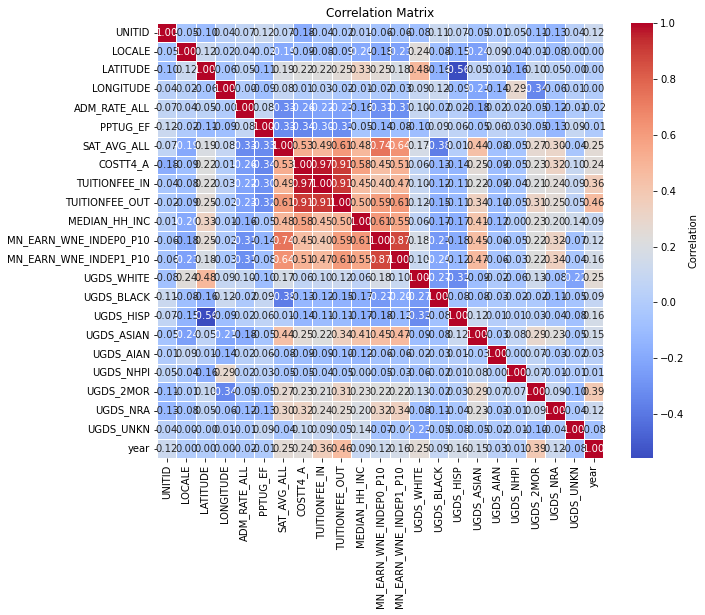

In [37]:
# assign correlation function to new variable
corr = df_colleges.corr()
corr

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=corr.isnull(), cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix')
plt.show()

## Release SageMaker Resources

In [38]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}